# Buynomics Revenue Optimisation

Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

Loading the product and sales data and merge them on the common column `product_id`.


In [4]:
product_df = pd.read_csv("data/product.csv")
sales_df = pd.read_csv("data/sales.csv")

df = pd.merge(sales_df, product_df, on='product_id')
df.head()

,Unnamed: 0_x,date,product_id,price,units,Unnamed: 0_y,brand,flavour,volume_per_joghurt_g,packsize
0,0,2020-01-01,0,4.65,1126.0,0,Mueller,blueberry,150,6
1,1,2020-01-02,0,4.76,1205.0,0,Mueller,blueberry,150,6
2,2,2020-01-03,0,5.22,1007.0,0,Mueller,blueberry,150,6
3,3,2020-01-04,0,5.45,1282.0,0,Mueller,blueberry,150,6
4,4,2020-01-05,0,3.33,1037.0,0,Mueller,blueberry,150,6


Removing rows with missing or zero prices/units and create helpful columns like `log_price`, `log_units`, and `revenue`.  


In [5]:
df = df[(df['price'] > 0) & (df['units'] > 0)]
df['log_price'] = np.log(df['price'])
df['log_units'] = np.log(df['units'])
df['revenue'] = df['price'] * df['units']

df.head()


,Unnamed: 0_x,date,product_id,price,units,Unnamed: 0_y,brand,flavour,volume_per_joghurt_g,packsize,log_price,log_units,revenue
0,0,2020-01-01,0,4.65,1126.0,0,Mueller,blueberry,150,6,1.536867,7.026427,5235.90
1,1,2020-01-02,0,4.76,1205.0,0,Mueller,blueberry,150,6,1.560248,7.094235,5735.80
2,2,2020-01-03,0,5.22,1007.0,0,Mueller,blueberry,150,6,1.652497,6.914731,5256.54
3,3,2020-01-04,0,5.45,1282.0,0,Mueller,blueberry,150,6,1.695616,7.156177,6986.90
4,4,2020-01-05,0,3.33,1037.0,0,Mueller,blueberry,150,6,1.202972,6.944087,3453.21


Generating plots to understand the relationship between price, units sold, and brand performance.


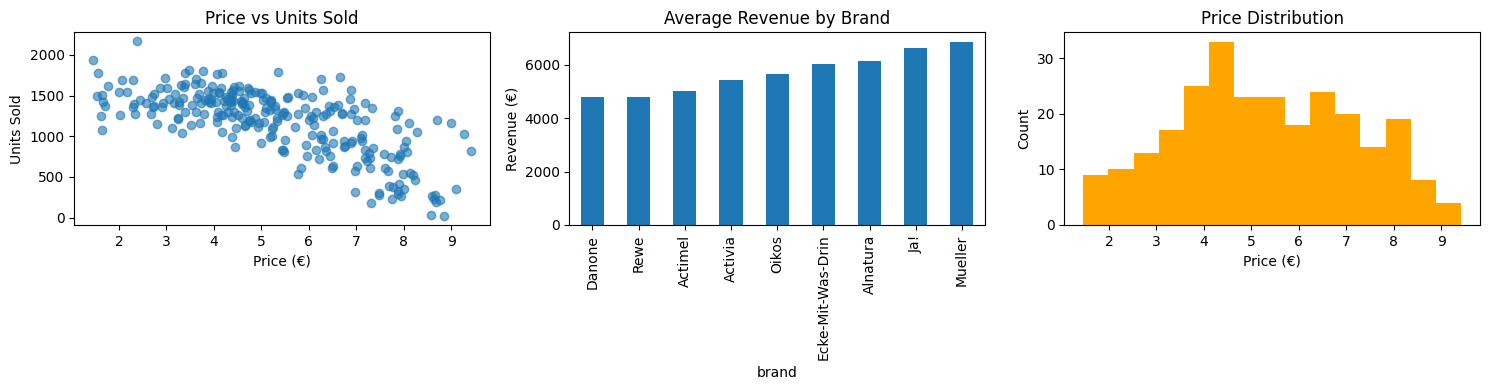

In [6]:
plt.figure(figsize=(15, 4))

# Price vs Units
plt.subplot(1, 3, 1)
plt.scatter(df['price'], df['units'], alpha=0.6)
plt.title("Price vs Units Sold")
plt.xlabel("Price (€)")
plt.ylabel("Units Sold")

# Avg Revenue by Brand
plt.subplot(1, 3, 2)
df.groupby('brand')['revenue'].mean().sort_values().plot(kind='bar')
plt.title("Average Revenue by Brand")
plt.ylabel("Revenue (€)")

# Price distribution
plt.subplot(1, 3, 3)
plt.hist(df['price'], bins=15, color='orange')
plt.title("Price Distribution")
plt.xlabel("Price (€)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


Including all product features, price, volume, pack size, brand, and flavour and converting bland and flavour into numbers using Label Encoding.

In [7]:
le_brand = LabelEncoder()
le_flavour = LabelEncoder()

df['brand_encoded'] = le_brand.fit_transform(df['brand'])
df['flavour_encoded'] = le_flavour.fit_transform(df['flavour'])

X = df[['log_price', 'volume_per_joghurt_g', 'packsize', 'brand_encoded', 'flavour_encoded']]
y = df['log_units']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

baseline_model = LinearRegression()
baseline_model.fit(X_train[['log_price']], y_train)


LinearRegression()

Evaluate the full model and compare it to a baseline using only price

In [8]:
y_pred = model.predict(X_test)
y_pred_baseline = baseline_model.predict(X_test[['log_price']])

print("Model Evaluation")
print("Coefficient of Determination (R²) - Full Model:", round(r2_score(y_test, y_pred), 3))
print("Coefficient of Determination (R²) - Baseline Model:", round(r2_score(y_test, y_pred_baseline), 3))
print("Mean Absolute Error (Full Model):", round(mean_absolute_error(np.exp(y_test), np.exp(y_pred)), 2))
print("Mean Absolute Error (Baseline Model):", round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_baseline)), 2))
print("Price Elasticity (Coefficient):", round(model.coef_[0], 3))


Model Evaluation
Coefficient of Determination (R²) - Full Model: 0.252
Coefficient of Determination (R²) - Baseline Model: 0.211
Mean Absolute Error (Full Model): 252.26
Mean Absolute Error (Baseline Model): 264.55
Price Elasticity (Coefficient): -0.347


Simulating Pricing Strategies  
Testing how changing price (by ±5% and ±10%) affects total revenue and units sold.

In [9]:
current_revenue = df['revenue'].sum()
current_units = df['units'].sum()

price_multipliers = [0.9, 0.95, 1.0, 1.05, 1.1]

print("Strategy Simulation Results")
for m in price_multipliers:
    new_prices = df['price'] * m
    X_sim = X.copy()
    X_sim['log_price'] = np.log(new_prices)

    predicted_units = np.exp(model.predict(X_sim))
    simulated_revenue = (new_prices * predicted_units).sum()
    simulated_units = predicted_units.sum()

    revenue_change = ((simulated_revenue - current_revenue) / current_revenue) * 100
    units_change = ((simulated_units - current_units) / current_units) * 100

    print("Price multiplier:", round(m, 2))
    print("Revenue change: ", round(revenue_change, 2), "%")
    print("Units sold change:", round(units_change, 2), "%")
    print("-" * 30)


Strategy Simulation Results
Price multiplier: 0.9
Revenue change:  -10.3 %
Units sold change: 0.32 %
------------------------------
Price multiplier: 0.95
Revenue change:  -7.08 %
Units sold change: -1.54 %
------------------------------
Price multiplier: 1.0
Revenue change:  -3.91 %
Units sold change: -3.28 %
------------------------------
Price multiplier: 1.05
Revenue change:  -0.8 %
Units sold change: -4.9 %
------------------------------
Price multiplier: 1.1
Revenue change:  2.26 %
Units sold change: -6.42 %
------------------------------


## Key Business Insight

**Optimal Strategy: 10% Price Increase**
- Revenue: +2.26% 
- Units Sold: -6.42% 
- **Net Result: Profitable** (inelastic demand, elasticity = -0.347)

**Recommendation:** The demand is price-inelastic, so moderate price increases can raise revenue without a large drop in sales.